# Article Relevance Prediction for NeotomaDB
## Model Iterations with Word Embeddings

This notebook contains the following tasks:
1. Import cleaned data from "../data/processed/metadata_processed.csv"
2. Add word embeddings
3. Train-Test split
4. Feature Selection
5. Hyperparameter tuning (with MLflow tracking)
6. Best Model

# 1. Import Data

In [1]:
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv, find_dotenv
import mlflow
import azureml
from mlflow.models.signature import infer_signature

load_dotenv(find_dotenv())

AZURE_MLFLOW_URI = os.environ.get("AZURE_MLFLOW_URI")
mlflow.set_tracking_uri(AZURE_MLFLOW_URI)

#### Create Training and Testing Data for Model Iteration 1 

In [2]:
import numpy as np
import pandas as pd
metadata_df = pd.read_csv("../../data/article-relevance/processed/metadata_processed.csv")
metadata_df.columns

Index(['Unnamed: 0', 'DOI', 'URL', 'abstract', 'author', 'container-title',
       'is-referenced-by-count', 'language', 'published', 'publisher',
       'subject', 'subtitle', 'title', 'target', 'published_year',
       'title_clean', 'subtitle_clean', 'abstract_clean', 'subject_clean',
       'has_abstract', 'text_with_abstract', 'text_wo_abstract', 'detectlang'],
      dtype='object')

In [3]:
training_keepcol = [
       'is-referenced-by-count', 
       'has_abstract', 
       'subject_clean',
       'text_with_abstract', 
       'target']

metadata_df_cleaned = metadata_df.loc[:, training_keepcol]

metadata_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4434 entries, 0 to 4433
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4434 non-null   int64 
 1   has_abstract            4434 non-null   int64 
 2   subject_clean           4346 non-null   object
 3   text_with_abstract      4434 non-null   object
 4   target                  4434 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 173.3+ KB


In [4]:
#empty strings being imported as NaN's, so filling with empty strings
metadata_df_cleaned['subject_clean'] = metadata_df_cleaned['subject_clean'].fillna(value='')

# 2. Add Sentance Embeddings

> !pip install sentence_transformers

In [5]:
metadata_df_cleaned.columns
from sentence_transformers import SentenceTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression 

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [6]:
def add_embedding(input_df, model_name = 'allenai/specter2'):
    # Joining embeddings to DataFrame
    model = SentenceTransformer(model_name)
    embeddings = input_df['text_with_abstract'].apply(model.encode)
    embeddings_formatted = pd.DataFrame(embeddings.tolist())
    model_name_file = model_name.replace('/', "_")
    embeddings_formatted.to_csv(f"../../data/article-relevance/raw/embeddings_{model_name_file}.csv")

    print("Embedding done.")

    embeddings_df = pd.read_csv(f"../../data/article-relevance/raw/embeddings_{model_name_file}.csv", index_col=0)
    embeddings_df.columns = embeddings_df.columns.astype(str) # require column names as strings for modelling

    result = pd.concat([input_df, embeddings_df], axis = 1)
    
    return result

def train_valid_test_split(dataframe):
    train_df, val_test_df = train_test_split(dataframe, test_size=0.3, random_state=123)
    valid_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=123)
    X_train, y_train = train_df.drop(columns = ["target", "text_with_abstract"]), train_df["target"]
    X_valid, y_valid = valid_df.drop(columns = ["target", "text_with_abstract"]), valid_df["target"]
    X_test, y_test = test_df.drop(columns = ["target", "text_with_abstract"]), test_df["target"]

    return train_df, valid_df, test_df, X_train, y_train, X_valid, y_valid, X_test, y_test


# Dividing the feature types
text_features = "subject_clean"
text_transformer = CountVectorizer(stop_words="english", max_features= 1000)

binary_feature = ['has_abstract']
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

numeric_features = ["is-referenced-by-count"]
numeric_transformer = StandardScaler()

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers = [
    ("num_preprocessor", numeric_transformer, numeric_features),
    ("binary_preprocessor", binary_transformer, binary_feature),
    ("text_preprocessor", text_transformer, text_features)
    ],
    remainder = "passthrough"
)
preprocessor

classification_metrics = ["recall", "f1", "accuracy", "precision"]

cross_val_results= {}
valid_split_result = {}
test_split_result = {}

### 2.1 mrm8488/bert-tiny-finetuned-squadv2 - LR

In [7]:
# Joining embeddings to DataFrame
metadata_df_squadv2 = add_embedding(input_df = metadata_df_cleaned, model_name = 'mrm8488/bert-tiny-finetuned-squadv2')
train_df, valid_df, test_df, X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(metadata_df_squadv2)

No sentence-transformers model found with name /Users/kw/.cache/torch/sentence_transformers/mrm8488_bert-tiny-finetuned-squadv2. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/kw/.cache/torch/sentence_transformers/mrm8488_bert-tiny-finetuned-squadv2 were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding done.


In [14]:
# The model pipeline
logreg_model = make_pipeline(preprocessor, LogisticRegression(class_weight = 'balanced', max_iter=10000, random_state=123))

cross_val_results['LR_bert_tiny'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

valid_split_result['LR_bert_tiny'] = pd.DataFrame({'metrics': [recall, precision, f1, accuracy]}, 
                                                  index= ['recall', 'precision', 'f1', 'accuracy'])

In [15]:
valid_split_result['LR_bert_tiny']

metrics
recall     0.923077
precision  0.809816
f1         0.862745
accuracy   0.936937

### 2.2 mrm8488/bert-tiny-finetuned-squadv2 - LGBM

In [20]:
from lightgbm.sklearn import LGBMClassifier

lbgm_model = make_pipeline(preprocessor, LGBMClassifier(class_weight="balanced", random_state=123))

cross_val_results['LGBM_bert_tiny'] = pd.DataFrame(
    cross_validate(
        lbgm_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

lbgm_model.fit(X_train, y_train)

y_pred = lbgm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

valid_split_result['LGBM_bert_tiny'] = pd.DataFrame({'metrics': [recall, precision, f1, accuracy]}, 
                                                  index= ['recall', 'precision', 'f1', 'accuracy'])


In [21]:
valid_split_result['LGBM_bert_tiny'] 

metrics
recall     0.839161
precision  0.923077
f1         0.879121
accuracy   0.950450

> high precision, low recal

### 2.3 Specter2 - LR

In [22]:
# Joining embeddings to DataFrame
metadata_df_specter2 = add_embedding(input_df = metadata_df_cleaned, model_name = 'allenai/specter2')
train_df, valid_df, test_df, X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(metadata_df_specter2)

No sentence-transformers model found with name /Users/kw/.cache/torch/sentence_transformers/allenai_specter2. Creating a new one with MEAN pooling.


Embedding done.


In [24]:
# The model pipeline
logreg_model = make_pipeline(preprocessor, LogisticRegression(class_weight = 'balanced', max_iter=10000, random_state=123))

cross_val_results['LR_specter2'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

valid_split_result['LR_specter2'] = pd.DataFrame({'metrics': [recall, precision, f1, accuracy]},
                                                 index= ['recall', 'precision', 'f1', 'accuracy']) 
valid_split_result['LR_specter2']

metrics
recall     0.944056
precision  0.882353
f1         0.912162
accuracy   0.960961

Results: 768 embeddings


### 2.4 Specter2 - LGBM

In [25]:
lbgm_model = make_pipeline(preprocessor, LGBMClassifier(class_weight="balanced", random_state=123))

cross_val_results['LGBM_specter2'] = pd.DataFrame(
    cross_validate(
        lbgm_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

lbgm_model.fit(X_train, y_train)

y_pred = lbgm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

valid_split_result['LGBM_specter2'] = pd.DataFrame({'metrics': [recall, precision, f1, accuracy]}, 
                                                  index= ['recall', 'precision', 'f1', 'accuracy'])
valid_split_result['LGBM_specter2']

metrics
recall     0.909091
precision  0.948905
f1         0.928571
accuracy   0.969970

>BioBert model was also tested. It's performance was mediocre and runtime was longer. Decide not to use it.

# 3. Train-Test Split

In [26]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [29]:
metadata_df_cleaned = metadata_df_specter2.copy()
train_df, val_test_df = train_test_split(metadata_df_cleaned, test_size=0.3, random_state=123)
valid_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=123)

train_df.head()

is-referenced-by-count  has_abstract  \
4221                       6             0   
3288                       0             0   
3869                       3             0   
3398                       0             0   
4196                       0             0   

                                          subject_clean  \
4221                                  Multidisciplinary   
3288  Infectious Diseases Public Health, Environment...   
3869             Pollution Aquatic Science Oceanography   
3398                                      Plant Science   
4196                                      Plant Science   

                                     text_with_abstract  target         0  \
4221  Maritime Paleoindian technology, subsistence, ...       0  0.579186   
3288  Mycetoma – a history of the first contribution...       0  0.477060   
3869  Diatom assemblages from sediment traps in resp...       0  0.128601   
3398  Fossil pollen resolves origin of the South Afr...       1  0.799006   
4196  The history of olive cultivation in the southe...       1  0.546940   

             1         2         3         4  ...       758       759  \
4221 -0.092632 -0.111798  0.193873  0.229161  ... -0.260911 -0.537787   
3288 -0.336245  0.225431  0.324308  0.580096  ... -0.302911  0.304369   
3869  0.088006  0.606217  0.963918  0.210807  ...  0.148401 -0.448286   
3398  0.072416  0.167970 -0.102468  0.250834  ... -0.448956 -0.085374   
4196  0.450331 -0.012919  0.462011  0.295008  ... -0.217269  0.090376   

           760       761       762       763       764       765       766  \
4221  0.293415 -0.576466 -0.481050 -0.332881 -0.605197 -0.119935 -0.106829   
3288  0.143716 -0.324644 -0.624726 -0.491619 -0.119483 -0.083295  0.154700   
3869  0.345021 -1.598382 -0.367895 -0.399962 -0.487801 -0.284578 -0.610243   
3398  0.315138 -0.389148  0.214994 -0.946495 -0.506957  0.467604  0.129413   
4196  0.170954 -0.344694 -0.606358 -0.744387 -0.732909  0.199213 -0.142942   

           767  
4221 -0.556662  
3288 -0.293703  
3869 -0.559385  
3398 -0.569880  
4196 -0.524134  

[5 rows x 773 columns]

### EDA for Train Split

In [30]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 4221 to 3582
Columns: 773 entries, is-referenced-by-count to 767
dtypes: float64(768), int64(3), object(2)
memory usage: 18.3+ MB


In [31]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

In [32]:
print("With Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_with_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_with_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_with_abstract.str.len().mean()
avg_neg_len = neg_df.text_with_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)

With Abstract
748.9921507064364
858.006893755069


In [34]:
sorted_pos_df.head()

is-referenced-by-count  has_abstract  \
362                       2             1   
436                       3             1   
438                      28             1   
194                      33             1   
210                       5             1   

                                         subject_clean  \
362                                                      
436  Plant Science Ecology, Evolution, Behavior and...   
438                                Atmospheric Science   
194                                            Geology   
210       Ecology, Evolution, Behavior and Systematics   

                                   text_with_abstract  target         0  \
362             Descriptions of WHOI sediment cores         1  0.270695   
436           5. Kožlí (S. Bohemia, Czech Republic)         1  0.206825   
438          Trees and climatic history in scotland         1  0.329712   
194         Tropical Lakes, Copropel, and Oil Shale         1 -0.157932   
210  Polar Bear and Mammoth on the Pribilof Islands         1  0.448533   

            1         2         3         4  ...       758       759  \
362 -0.074686 -0.274900  0.551651  0.388572  ... -0.103762 -0.809462   
436  0.580800 -0.010444  0.603886  0.680180  ... -0.275659 -0.123723   
438  0.120227  0.376346 -0.458929  0.782681  ...  0.192091  0.565751   
194 -0.387156  0.321566  0.293862  0.397264  ...  0.104274 -0.106874   
210  0.842923  0.009119  0.082520  0.345019  ... -0.755409 -0.301973   

          760       761       762       763       764       765       766  \
362  0.060872 -1.325215 -0.364120 -0.088221 -0.084968 -0.103741 -0.974078   
436  0.392365 -1.093518 -0.805285 -0.461480 -0.266015 -0.295602 -0.391322   
438  0.024175 -0.998432 -0.805124 -0.843952 -0.341194  0.176454 -0.504945   
194  0.043313 -1.219272 -0.219073 -0.446062 -0.039384 -0.022078 -0.867640   
210  0.779209 -1.429810 -0.071458 -0.798733 -0.277052  0.101801 -0.288858   

          767  
362 -1.038606  
436 -0.405015  
438 -0.465813  
194 -0.833833  
210 -0.246020  

[5 rows x 773 columns]

In [35]:
sorted_neg_df.head()

is-referenced-by-count  has_abstract  \
1557                       0             1   
960                        0             1   
1724                       0             1   
933                        0             1   
2332                       0             1   

                                          subject_clean text_with_abstract  \
1557  Computational Theory and Mathematics Computer ...             Note     
960                      General Medicine Small Animals            Index     
1724                         Economics and Econometrics            Reply     
933   Space and Planetary Science Aerospace Engineering           Awards     
2332                                      Small Animals           Errata     

      target         0         1         2         3         4  ...       758  \
1557       0  0.819647  0.953706 -0.312233  0.111058  0.206494  ... -0.499195   
960        0  1.047370  0.766372 -0.317631  0.428348  0.392411  ... -0.192978   
1724       0  0.752726  1.042939 -0.234512 -0.106807  0.114119  ... -0.392654   
933        0  0.551992  0.842005 -0.036979 -0.104208 -0.114465  ... -0.435892   
2332       0  0.811976  0.790851 -0.109971 -0.075480  0.089221  ... -0.550840   

           759       760       761       762       763       764       765  \
1557 -0.087896  0.008512 -0.991749 -0.641762 -0.654255 -0.428303 -0.158791   
960  -0.154775 -0.081871 -0.882535 -0.075180 -0.389105 -0.520646 -0.391229   
1724  0.433179 -0.051479 -0.691991 -0.406836 -0.589678 -0.101129 -0.055551   
933   0.060853 -0.251164 -0.422522 -0.588880 -0.170932 -0.693326 -0.255663   
2332  0.525734  0.181635 -0.680848 -0.446255 -0.600082 -0.223956 -0.290715   

           766       767  
1557 -0.835710 -0.457620  
960  -0.707228 -0.600387  
1724 -0.974585 -0.991617  
933  -0.549102 -0.686606  
2332 -0.803426 -0.690272  

[5 rows x 773 columns]

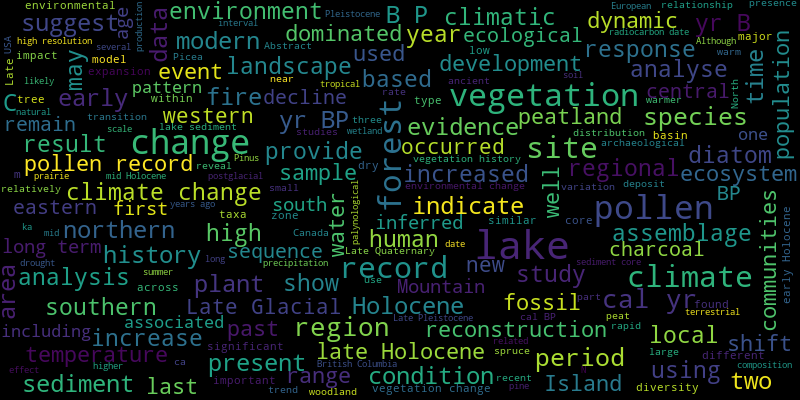

In [36]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text_with_abstract"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text_with_abstract"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

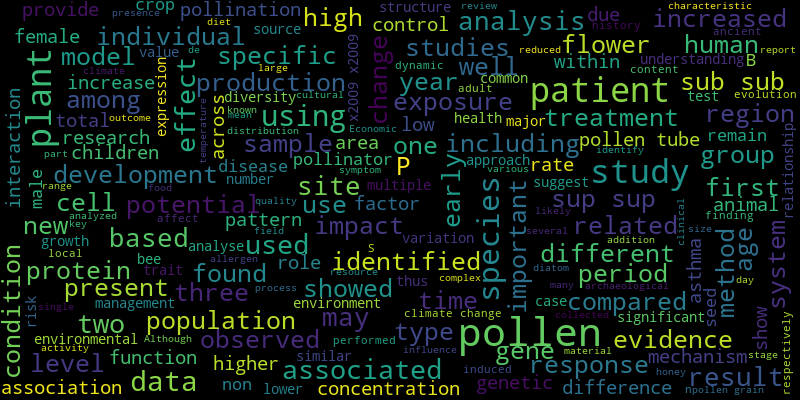

In [37]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [38]:
train_df["target"].value_counts(normalize=True)

0    0.794715
1    0.205285
Name: target, dtype: float64

# 4. Modelling with Sentence Embeddings

### 4.1 Preprocessor

In [39]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [40]:
train_df.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target', '0', '1', '2', '3', '4',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=773)

In [41]:
X_train, y_train = train_df.drop(columns = ["target", "text_with_abstract"]), train_df["target"]
X_valid, y_valid = train_df.drop(columns = ["target", "text_with_abstract"]), train_df["target"]
X_test, y_test = test_df.drop(columns = ["target", "text_with_abstract"]), test_df["target"]

In [42]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer

# Dividing the feature types
text_features = "subject_clean"
text_transformer = CountVectorizer(stop_words="english", max_features= 1000)

binary_feature = ['has_abstract']
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

numeric_features = ["is-referenced-by-count"]
numeric_transformer = StandardScaler()

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers = [
    ("num_preprocessor", numeric_transformer, numeric_features),
    ("binary_preprocessor", binary_transformer, binary_feature),
    ("text_preprocessor", text_transformer, text_features)
    ],
    remainder = "passthrough"
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_preprocessor', StandardScaler(),
                                 ['is-referenced-by-count']),
                                ('binary_preprocessor',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['has_abstract']),
                                ('text_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'subject_clean')])

##### Check Transformed Data

In [107]:
transformed_X_train = preprocessor.fit_transform(X_train)
embedding_col = [str(num) for num in range(768)]

col_names = (preprocessor.named_transformers_["num_preprocessor"].get_feature_names_out().tolist() +
             preprocessor.named_transformers_["binary_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist() + 
             embedding_col)

transformed_X_train_df = pd.DataFrame(transformed_X_train, columns=col_names, index = X_train.index)


In [108]:
transformed_X_train_df.index

Int64Index([4221, 3288, 3869, 3398, 4196, 1708,  923, 2426, 2562, 1941,
            ...
             111,  942, 4169, 4143,   96, 1593, 4060, 1346, 3454, 3582],
           dtype='int64', length=3103)

In [44]:
transformed_X_train_df = pd.DataFrame(transformed_X_train, columns=col_names)
transformed_X_train_df.head(3)

is-referenced-by-count  has_abstract_1  accounting  administration  \
0               -0.224594             0.0         0.0             0.0   
1               -0.377734             0.0         0.0             0.0   
2               -0.301164             0.0         0.0             0.0   

   advanced  aerospace  aging  agricultural  agronomy  aided  ...       758  \
0       0.0        0.0    0.0           0.0       0.0    0.0  ... -0.260911   
1       0.0        0.0    0.0           0.0       0.0    0.0  ... -0.302911   
2       0.0        0.0    0.0           0.0       0.0    0.0  ...  0.148401   

        759       760       761       762       763       764       765  \
0 -0.537787  0.293415 -0.576466 -0.481050 -0.332881 -0.605197 -0.119935   
1  0.304369  0.143716 -0.324644 -0.624726 -0.491619 -0.119483 -0.083295   
2 -0.448286  0.345021 -1.598382 -0.367895 -0.399962 -0.487801 -0.284578   

        766       767  
0 -0.106829 -0.556662  
1  0.154700 -0.293703  
2 -0.610243 -0.559385  

[3 rows x 1088 columns]

### 4.2 Model Comparison

In [45]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [46]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [47]:
classification_metrics = ["recall", "accuracy", "f1", "precision"]

In [49]:
results_dict = {}
models = {
	"dummy": DummyClassifier(random_state = 123),
    'Logistic Regression': LogisticRegression(class_weight="balanced", max_iter=1000, random_state=123),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    'Naive Bayes': BernoulliNB(),
    "RBF SVM": SVC(class_weight="balanced", random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(class_weight="balanced", random_state=123),
    # 'CatBoost': CatBoostClassifier(verbose=0, random_state=123),
    'XGBoost': XGBClassifier(class_weight="balanced", random_state=123, verbosity=0),
    'sklearn_histGB': HistGradientBoostingClassifier(random_state=123),
    'sklearn_GB': GradientBoostingClassifier(random_state=123)
    }

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df


/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

fit_time         score_time        test_recall  \
dummy                 0.045 (+/- 0.009)  0.017 (+/- 0.002)  0.000 (+/- 0.000)   
Logistic Regression   0.546 (+/- 0.134)  0.017 (+/- 0.001)  0.912 (+/- 0.033)   
Decision Tree         1.483 (+/- 0.174)  0.015 (+/- 0.002)  0.750 (+/- 0.038)   
kNN                   0.035 (+/- 0.001)  0.076 (+/- 0.035)  0.870 (+/- 0.022)   
Naive Bayes           0.066 (+/- 0.004)  0.022 (+/- 0.003)  0.967 (+/- 0.010)   
RBF SVM               0.781 (+/- 0.092)  0.206 (+/- 0.061)  0.948 (+/- 0.030)   
RF                    2.766 (+/- 0.051)  0.027 (+/- 0.001)  0.807 (+/- 0.022)   
LGBM                  2.498 (+/- 0.168)  0.022 (+/- 0.002)  0.893 (+/- 0.033)   
XGBoost               4.657 (+/- 0.368)  0.028 (+/- 0.003)  0.892 (+/- 0.032)   
sklearn_histGB        6.357 (+/- 0.561)  0.020 (+/- 0.001)  0.892 (+/- 0.041)   
sklearn_GB           47.659 (+/- 0.348)  0.016 (+/- 0.002)  0.871 (+/- 0.034)   

                          train_recall      test_accuracy     train_accuracy  \
dummy                0.000 (+/- 0.000)  0.795 (+/- 0.001)  0.795 (+/- 0.000)   
Logistic Regression  1.000 (+/- 0.001)  0.956 (+/- 0.011)  0.995 (+/- 0.001)   
Decision Tree        1.000 (+/- 0.000)  0.904 (+/- 0.010)  1.000 (+/- 0.000)   
kNN                  0.911 (+/- 0.007)  0.962 (+/- 0.005)  0.975 (+/- 0.001)   
Naive Bayes          0.970 (+/- 0.002)  0.908 (+/- 0.006)  0.909 (+/- 0.002)   
RBF SVM              0.978 (+/- 0.004)  0.955 (+/- 0.010)  0.967 (+/- 0.003)   
RF                   1.000 (+/- 0.000)  0.954 (+/- 0.004)  1.000 (+/- 0.000)   
LGBM                 1.000 (+/- 0.000)  0.966 (+/- 0.006)  1.000 (+/- 0.000)   
XGBoost              1.000 (+/- 0.000)  0.967 (+/- 0.006)  1.000 (+/- 0.000)   
sklearn_histGB       1.000 (+/- 0.000)  0.969 (+/- 0.007)  1.000 (+/- 0.000)   
sklearn_GB           1.000 (+/- 0.000)  0.963 (+/- 0.006)  1.000 (+/- 0.000)   

                               test_f1           train_f1     test_precision  \
dummy                0.000 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
Logistic Regression  0.894 (+/- 0.024)  0.987 (+/- 0.002)  0.878 (+/- 0.036)   
Decision Tree        0.763 (+/- 0.027)  1.000 (+/- 0.000)  0.776 (+/- 0.020)   
kNN                  0.904 (+/- 0.014)  0.938 (+/- 0.002)  0.942 (+/- 0.018)   
Naive Bayes          0.813 (+/- 0.010)  0.814 (+/- 0.004)  0.701 (+/- 0.015)   
RBF SVM              0.896 (+/- 0.023)  0.924 (+/- 0.006)  0.850 (+/- 0.024)   
RF                   0.878 (+/- 0.013)  1.000 (+/- 0.000)  0.963 (+/- 0.006)   
LGBM                 0.915 (+/- 0.016)  1.000 (+/- 0.000)  0.939 (+/- 0.015)   
XGBoost              0.917 (+/- 0.016)  1.000 (+/- 0.000)  0.945 (+/- 0.003)   
sklearn_histGB       0.921 (+/- 0.019)  1.000 (+/- 0.000)  0.953 (+/- 0.010)   
sklearn_GB           0.905 (+/- 0.018)  1.000 (+/- 0.000)  0.942 (+/- 0.006)   

                       train_precision  
dummy                0.000 (+/- 0.000)  
Logistic Regression  0.974 (+/- 0.005)  
Decision Tree        1.000 (+/- 0.000)  
kNN                  0.968 (+/- 0.005)  
Naive Bayes          0.702 (+/- 0.006)  
RBF SVM              0.876 (+/- 0.009)  
RF                   1.000 (+/- 0.000)  
LGBM                 1.000 (+/- 0.000)  
XGBoost              1.000 (+/- 0.000)  
sklearn_histGB       1.000 (+/- 0.000)  
sklearn_GB           1.000 (+/- 0.000)

##### Summary of models
- Naive Bayes has the highest test recall but the precision is too low and will introduce many false positives.
- sklearn_GB and CatBoost has high f1 but their fit time is very long - not practical
- logistic regression and LGBM has high recall, f1 and reasonable fit time and precision
- RBF SVM has good performance on recall, but precision is lower than logistic regression.
- Consideration: model interpretability.


### 4.3 Logistic Regression Model Evaluation

##### Logistic Regression - Without hyperparameter tuning/Feature selection

> There is a little sign of overfitting for logistic regression. We will try feature selection and compare the performance in the next step.
> Here, we are first getting a sense of how logistic regression perform without feature selection, and how the coefficients looks like at the moment. & Checking the hyperparameter values selected automatically by scikit learn

In [52]:
from sklearn.linear_model import LogisticRegression 

# The model pipeline
logreg_model = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced", max_iter=10000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe

classification_metrics = ["recall", "f1", "accuracy", "precision"]

cross_val_results= {}
cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

mean    std
fit_time         0.581  0.088
score_time       0.017  0.001
test_recall      0.912  0.033
train_recall     1.000  0.001
test_f1          0.894  0.024
train_f1         0.987  0.002
test_accuracy    0.956  0.011
train_accuracy   0.995  0.001
test_precision   0.878  0.036
train_precision  0.974  0.005

##### Feature importance for Logistic Regression

In [53]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [56]:
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    random_state=123))])

In [57]:
data = {
    "coefficient": logreg_model.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

coefficient  magnitude
archeology       1.603946   1.603946
266              0.935162   0.935162
paleontology     0.905358   0.905358
98               0.901789   0.901789
435              0.870517   0.870517
581              0.823432   0.823432
155              0.813350   0.813350
plant            0.804583   0.804583
357              0.796842   0.796842
355              0.777953   0.777953
645              0.774993   0.774993
17               0.760880   0.760880
88               0.754329   0.754329
732              0.751171   0.751171
767              0.746729   0.746729
28               0.736865   0.736865
earth            0.728381   0.728381
532              0.726672   0.726672
268              0.713226   0.713226
66               0.712840   0.712840
419              0.694127   0.694127
350              0.680437   0.680437
267              0.676495   0.676495
117              0.667072   0.667072
691              0.665184   0.665184
306              0.663509   0.663509
technology       0.662568   0.662568
649              0.661672   0.661672
167              0.659791   0.659791
198              0.657980   0.657980

In [58]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

coefficient  magnitude
multidisciplinary    -1.481149   1.481149
718                  -1.052560   1.052560
55                   -1.024120   1.024120
761                  -0.981127   0.981127
202                  -0.918883   0.918883
80                   -0.912003   0.912003
561                  -0.858692   0.858692
25                   -0.842352   0.842352
393                  -0.816468   0.816468
175                  -0.789976   0.789976
310                  -0.771930   0.771930
560                  -0.716381   0.716381
723                  -0.695125   0.695125
647                  -0.676681   0.676681
462                  -0.668046   0.668046
genetics             -0.666408   0.666408
37                   -0.665160   0.665160
engineering          -0.651139   0.651139
152                  -0.645217   0.645217
442                  -0.643118   0.643118
291                  -0.639803   0.639803
231                  -0.630359   0.630359
654                  -0.627845   0.627845
199                  -0.627713   0.627713
673                  -0.627396   0.627396
177                  -0.618202   0.618202
225                  -0.613647   0.613647
460                  -0.612289   0.612289
277                  -0.611931   0.611931
149                  -0.596807   0.596807

In [59]:
from sklearn.metrics import recall_score
# Make predictions
predictions = logreg_model.predict(X_train)

# Add the predictions to the original DataFrame
train_df['predictions'] = predictions

# Group the data by a specific feature
grouped_data = train_df.groupby('has_abstract')

# Calculate recall for each group
grouped_recall = grouped_data.apply(lambda x: recall_score(x['target'], x['predictions']))

# Print the recall by group
print(grouped_recall)

has_abstract
0    1.0
1    1.0
dtype: float64


### 4.4 Feature Selection

In [37]:
from sklearn.feature_selection import SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results_dict[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=classification_metrics
    )

In [38]:
pd.DataFrame(results_dict).T

fit_time         score_time  \
dummy                           0.071 (+/- 0.005)  0.027 (+/- 0.002)   
logistic regression             1.150 (+/- 0.261)  0.033 (+/- 0.013)   
decision tree                   3.496 (+/- 0.129)  0.021 (+/- 0.004)   
kNN                             0.058 (+/- 0.016)  0.253 (+/- 0.058)   
NaiveBayes                      0.126 (+/- 0.016)  0.041 (+/- 0.004)   
RBF SVM                         0.649 (+/- 0.025)  0.289 (+/- 0.067)   
RF                              4.309 (+/- 0.167)  0.041 (+/- 0.008)   
LGBM                           11.065 (+/- 0.848)  0.029 (+/- 0.007)   
XGB                            23.929 (+/- 6.230)  0.030 (+/- 0.010)   
sklearn_histGB                 12.828 (+/- 0.434)  0.032 (+/- 0.002)   
sklearn_GB                     71.034 (+/- 0.546)  0.021 (+/- 0.001)   
logistic regression+ feat_sel   0.656 (+/- 0.092)  0.033 (+/- 0.013)   
decision tree+ feat_sel         1.091 (+/- 0.184)  0.024 (+/- 0.006)   
NaiveBayes+ feat_sel            0.471 (+/- 0.047)  0.029 (+/- 0.001)   
RBF SVM+ feat_sel               0.591 (+/- 0.054)  0.088 (+/- 0.024)   
RF+ feat_sel                    2.371 (+/- 0.364)  0.036 (+/- 0.003)   
LGBM+ feat_sel                  2.238 (+/- 0.465)  0.026 (+/- 0.006)   
XGB+ feat_sel                   4.180 (+/- 0.733)  0.026 (+/- 0.007)   
sklearn_histGB+ feat_sel        2.425 (+/- 0.332)  0.028 (+/- 0.006)   
sklearn_GB+ feat_sel           12.882 (+/- 0.875)  0.028 (+/- 0.006)   

                                   test_accuracy     train_accuracy  \
dummy                          0.794 (+/- 0.001)  0.794 (+/- 0.000)   
logistic regression            0.967 (+/- 0.004)  0.996 (+/- 0.001)   
decision tree                  0.908 (+/- 0.008)  1.000 (+/- 0.000)   
kNN                            0.966 (+/- 0.007)  0.975 (+/- 0.001)   
NaiveBayes                     0.913 (+/- 0.013)  0.914 (+/- 0.004)   
RBF SVM                        0.968 (+/- 0.004)  0.976 (+/- 0.001)   
RF                             0.957 (+/- 0.005)  1.000 (+/- 0.000)   
LGBM                           0.969 (+/- 0.006)  1.000 (+/- 0.000)   
XGB                            0.967 (+/- 0.006)  1.000 (+/- 0.000)   
sklearn_histGB                 0.969 (+/- 0.006)  1.000 (+/- 0.000)   
sklearn_GB                     0.962 (+/- 0.005)  1.000 (+/- 0.000)   
logistic regression+ feat_sel  0.965 (+/- 0.007)  0.990 (+/- 0.001)   
decision tree+ feat_sel        0.906 (+/- 0.013)  1.000 (+/- 0.000)   
NaiveBayes+ feat_sel           0.933 (+/- 0.012)  0.944 (+/- 0.006)   
RBF SVM+ feat_sel              0.965 (+/- 0.004)  0.974 (+/- 0.001)   
RF+ feat_sel                   0.957 (+/- 0.005)  1.000 (+/- 0.000)   
LGBM+ feat_sel                 0.966 (+/- 0.006)  1.000 (+/- 0.000)   
XGB+ feat_sel                  0.967 (+/- 0.004)  1.000 (+/- 0.000)   
sklearn_histGB+ feat_sel       0.965 (+/- 0.007)  1.000 (+/- 0.000)   
sklearn_GB+ feat_sel           0.964 (+/- 0.006)  1.000 (+/- 0.000)   

                                  test_precision    train_precision  \
dummy                          0.000 (+/- 0.000)  0.000 (+/- 0.000)   
logistic regression            0.934 (+/- 0.012)  0.995 (+/- 0.003)   
decision tree                  0.779 (+/- 0.029)  1.000 (+/- 0.000)   
kNN                            0.964 (+/- 0.012)  0.971 (+/- 0.006)   
NaiveBayes                     0.713 (+/- 0.032)  0.714 (+/- 0.009)   
RBF SVM                        0.964 (+/- 0.008)  0.978 (+/- 0.005)   
RF                             0.966 (+/- 0.007)  1.000 (+/- 0.000)   
LGBM                           0.952 (+/- 0.022)  1.000 (+/- 0.000)   
XGB                            0.948 (+/- 0.017)  1.000 (+/- 0.000)   
sklearn_histGB                 0.952 (+/- 0.020)  1.000 (+/- 0.000)   
sklearn_GB                     0.938 (+/- 0.009)  1.000 (+/- 0.000)   
logistic regression+ feat_sel  0.931 (+/- 0.022)  0.987 (+/- 0.005)   
decision tree+ feat_sel        0.777 (+/- 0.038)  1.000 (+/- 0.000)   
NaiveBayes+ feat_sel           0.784 (+/- 

In [39]:
pipe_LGBM = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["LGBM"],
)

pipe_LGBM.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_LGBM.named_steps["lgbmclassifier"].n_features_in_,
)

Number of features selected:  178


In [40]:
pipe_logreg = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["logistic regression"],
)

pipe_logreg.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_logreg.named_steps["logisticregression"].n_features_in_,
)

Number of features selected:  180


#### Results
It appears that feature selection comes at a cost of performance (i.e. lower recall) does not provide us with better results. 

# 5. Hyperparmeter Optimization

In [61]:
# !pip install hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

In [62]:
metrics = ["recall", "f1", "accuracy", "precision"]

def objective(params):

    classifier_type = params['type']
    del params['type']

    if classifier_type == 'logistic_regression':
        clf = LogisticRegression(class_weight = "balanced", max_iter=10000, random_state=123, **params)
    elif classifier_type == 'lgbm':
        clf = LGBMClassifier(class_weight = "balanced", random_state=123, **params)
    else:
        return 0

    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", clf),
        ]
    )

    # manually run cross_validate and get recall
    model_cv_results = pd.DataFrame(cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=metrics,
        return_train_score=True,
        n_jobs=-1,
    )).agg(["mean", "std"]).T
    
    # log metrics to mlflow
    with mlflow.start_run():

        # log train and test for each metric
        for m in metrics:
            mlflow.log_metric(f"{m}_train_mean", model_cv_results.loc[f"train_{m}"]["mean"])
            mlflow.log_metric(f"{m}_test_mean", model_cv_results.loc[f"test_{m}"]["mean"])
            mlflow.log_metric(f"{m}_train_std", model_cv_results.loc[f"train_{m}"]["std"])
            mlflow.log_metric(f"{m}_test_std", model_cv_results.loc[f"test_{m}"]["std"])

        # log params
        mlflow.log_params(params)
        # log the type of model
        mlflow.log_param("model_type", classifier_type)

        # log model
        if classifier_type == "lgbm":
            mlflow.lightgbm.log_model(pipe, "model", signature=infer_signature(X_train, y_train))
        elif classifier_type == "logistic_regression":
            mlflow.sklearn.log_model(pipe, "model", signature=infer_signature(X_train, y_train))

    # make recall positive so it maximizes it 
    result = {'loss': -model_cv_results.loc["test_" + metrics[0]]["mean"], 
              'status': STATUS_OK}

    return result

### 5.1 Logistic Regression Hyperparameter Tuning

In [63]:
# mlflow.set_experiment("kw_recall_final_LR_100")

# search_space = hp.choice('classifier_type', [
#     {
#         'type': 'logistic_regression',
#         'C': hp.uniform('logisticregression__C', 0.01, 30),
#     }
# ])

# search_algorithm = tpe.suggest

# best_lr_hyperparams = fmin(
# fn=objective, 
# space=search_space,
# algo=search_algorithm,
# max_evals=100,
# trials= Trials())

In [64]:
# best_lr_hyperparams_saved = {'classifier_type': 0, 'logisticregression__C': 0.01563028103558011}

In [65]:
best_lr_hyperparams = {'classifier_type': 0, 'logisticregression__C': 0.01563028103558011}

In [66]:
best_model_lr = make_pipeline(
    preprocessor, LogisticRegression(class_weight='balanced', max_iter=10_000, random_state=123, C=best_lr_hyperparams['logisticregression__C'])
)
best_model_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(C=0.01563028103558011,
                                    class_weight='balanced', max_iter=10000,
                                    random_state=123))])

In [68]:
# On validation set
preds = best_model_lr.predict(X_valid)
print('f1:', f1_score(y_valid, preds))
print('recall:', recall_score(y_valid, preds))
print('precision:', precision_score(y_valid, preds))

f1: 0.9014084507042254
recall: 0.9770992366412213
precision: 0.8366013071895425


In [69]:
# On test set
preds = best_model_lr.predict(X_test)
print('f1:', f1_score(y_test, preds))
print('recall:', recall_score(y_test, preds))
print('precision:', precision_score(y_test, preds))

f1: 0.9049180327868852
recall: 0.965034965034965
precision: 0.8518518518518519


### 5.2 LGBM Hyperparameter Tuning

In [70]:
from hyperopt.early_stop import no_progress_loss

In [71]:
# mlflow.set_experiment("kw_iteration1_LGBM100_noEarlyStop")

# search_space = hp.choice('classifier_type', [
#     {
#         'type': 'lgbm',
#         'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
#         'max_depth': hp.uniformint('max_depth', 10, 40),
#         # 'class_weight': hp.choice('class_weight', ["balanced", None]),
#         'n_estimators': hp.uniformint('n_estimators', 100, 300),
#     }
# ])

# search_algorithm = tpe.suggest

# best_hyperparams = fmin(
# fn=objective, 
# space=search_space,
# algo=search_algorithm,
# max_evals=100,
# # early_stop_fn=no_progress_loss(10),
# trials= Trials())

In [72]:
best_lgbm_para_saved = {'classifier_type': 0, 'learning_rate': 0.3318019427821558, 'max_depth': 22.0, 'n_estimators': 420.0}

In [73]:
best_hyperparams = best_lgbm_para_saved

In [74]:
best_model = make_pipeline(
    preprocessor, LGBMClassifier(
        learning_rate = best_hyperparams['learning_rate'], 
        max_depth = int(best_hyperparams['max_depth']), 
        n_estimators = int(best_hyperparams['n_estimators']))
)
best_model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.3318019427821558, max_depth=22,
                                n_estimators=420))])

In [76]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["non-relevant", "relevant"]))


              precision    recall  f1-score   support

non-relevant       0.98      0.98      0.98       523
    relevant       0.94      0.91      0.93       143

    accuracy                           0.97       666
   macro avg       0.96      0.95      0.95       666
weighted avg       0.97      0.97      0.97       666



In [77]:
# On validation set
preds = best_model.predict(X_valid)
print('f1:', f1_score(y_valid, preds))
print('recall:', recall_score(y_valid, preds))
print('precision:', precision_score(y_valid, preds))

f1: 0.9453124999999999
recall: 0.9236641221374046
precision: 0.968


In [78]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model.predict(X_test)
print('f1:', f1_score(y_test, preds))
print('recall:', recall_score(y_test, preds))
print('precision:', precision_score(y_test, preds))

f1: 0.9252669039145908
recall: 0.9090909090909091
precision: 0.9420289855072463


In [ ]:
# Export the best model
import joblib
joblib.dump(best_model_lr, '../../models/article-relevance/logistic_regression_model.joblib')

# Final Model Evaluation

#### 6.1 Threshold Adjustment

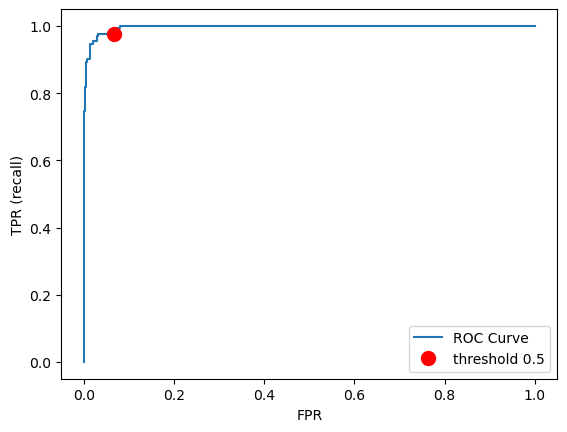

In [79]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid, best_model_lr.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [81]:
from sklearn.metrics import confusion_matrix

def threshold_adj(thld = 0.5):
    proba = best_model_lr.predict_proba(X_valid)[:, 1]
    predictions = np.array([1 if prob > thld else 0 for prob in proba])
    TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = (2 * precision * recall) / (precision + recall)
    print(f"(threshold = {thld}) validation set's precision = {round(precision, 3)}, recall = {round(recall, 3)} & f1 = {round(f1_score, 3)}")
    print(f"False negative = {FN}, False positive = {FP}")
    print(f"True negative = {TN}, True positive = {TP}")

threshold_adj(thld = 0.6)
threshold_adj(thld = 0.5)
threshold_adj(thld = 0.4)
threshold_adj(thld = 0.3)

(threshold = 0.6) validation set's precision = 0.919, recall = 0.947 & f1 = 0.932
False negative = 7, False positive = 11
True negative = 523, True positive = 124
(threshold = 0.5) validation set's precision = 0.837, recall = 0.977 & f1 = 0.901
False negative = 3, False positive = 25
True negative = 509, True positive = 128
(threshold = 0.4) validation set's precision = 0.769, recall = 0.992 & f1 = 0.867
False negative = 1, False positive = 39
True negative = 495, True positive = 130
(threshold = 0.3) validation set's precision = 0.701, recall = 1.0 & f1 = 0.824
False negative = 0, False positive = 56
True negative = 478, True positive = 131


> Decision: Keep the threshold at 0.5 for now since the recall is already decent. 

> This threshold is parametrized in the prediction pipeline script. In the future when there are more new data for retraining, the threshold can be further finetuned.


(666, 771)

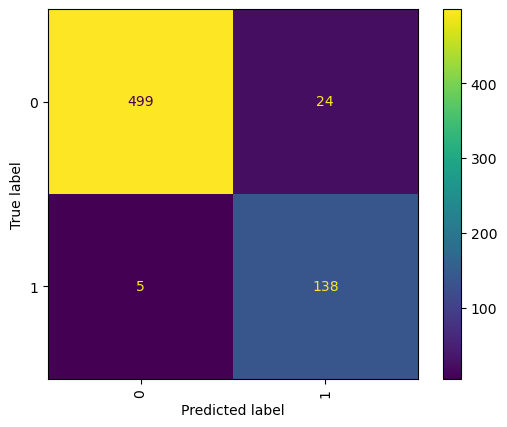

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model_lr, X_test, y_test, xticks_rotation="vertical")
X_test.shape

#### 6.2 Feature importance 

In [83]:
data = {
    "coefficient": best_model_lr.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        best_model_lr.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

In [84]:
# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

coefficient  magnitude
archeology                 0.320796   0.320796
334                        0.224541   0.224541
earth                      0.195176   0.195176
362                        0.190722   0.190722
732                        0.187103   0.187103
100                        0.174112   0.174112
102                        0.171849   0.171849
445                        0.171131   0.171131
planetary                  0.158464   0.158464
205                        0.156883   0.156883
448                        0.154865   0.154865
581                        0.153051   0.153051
is-referenced-by-count     0.149549   0.149549
155                        0.145032   0.145032
266                        0.141843   0.141843
36                         0.141529   0.141529
699                        0.140134   0.140134
573                        0.137243   0.137243
paleontology               0.135254   0.135254
357                        0.133365   0.133365
745                        0.131428   0.131428
604                        0.130624   0.130624
441                        0.130417   0.130417
226                        0.127762   0.127762
435                        0.127130   0.127130
532                        0.125186   0.125186
130                        0.123342   0.123342
45                         0.123062   0.123062
103                        0.123022   0.123022
367                        0.121480   0.121480

In [85]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

coefficient  magnitude
723                  -0.211918   0.211918
multidisciplinary    -0.210629   0.210629
761                  -0.192873   0.192873
718                  -0.190370   0.190370
724                  -0.172051   0.172051
466                  -0.167726   0.167726
202                  -0.165633   0.165633
55                   -0.147184   0.147184
132                  -0.142121   0.142121
458                  -0.141339   0.141339
442                  -0.139547   0.139547
615                  -0.137865   0.137865
425                  -0.137388   0.137388
215                  -0.136020   0.136020
666                  -0.132542   0.132542
25                   -0.128013   0.128013
209                  -0.128010   0.128010
181                  -0.126254   0.126254
422                  -0.124683   0.124683
299                  -0.122657   0.122657
301                  -0.120556   0.120556
339                  -0.120165   0.120165
125                  -0.118694   0.118694
525                  -0.118576   0.118576
374                  -0.118343   0.118343
562                  -0.114411   0.114411
393                  -0.114259   0.114259
109                  -0.112048   0.112048
149                  -0.110451   0.110451
1                    -0.110067   0.110067

In [109]:
transformed_X_train_df_target = pd.merge(transformed_X_train_df, y_train, left_index=True, right_index=True)

In [111]:
transformed_X_train_df_target.shape

(3103, 1089)

In [113]:
transformed_X_train_df_target['predict_proba'] = best_model_lr.predict_proba(X_train)[:, 1]
transformed_X_train_df_target['prediction'] = best_model_lr.predict(X_train)

In [114]:
# Check subject distribution in two target groups
subject_words = ['archeology', 'planetary', 'paleontology', 'plant', 'earth', 'multidisciplinary']

for word in subject_words:
    print("======= ", word, ' ========')
    print("counts in two groups")
    print(transformed_X_train_df_target.groupby('target')[word].sum())
    print("percentage in two groups")
    print(transformed_X_train_df_target.groupby('target')[word].sum()/transformed_X_train_df_target.groupby('target')[word].count())

=======  archeology  ========
counts in two groups
target
0     25.0
1    209.0
Name: archeology, dtype: float64
percentage in two groups
target
0    0.010138
1    0.328100
Name: archeology, dtype: float64
=======  planetary  ========
counts in two groups
target
0     48.0
1    225.0
Name: planetary, dtype: float64
percentage in two groups
target
0    0.019465
1    0.353218
Name: planetary, dtype: float64
=======  paleontology  ========
counts in two groups
target
0      5.0
1    147.0
Name: paleontology, dtype: float64
percentage in two groups
target
0    0.002028
1    0.230769
Name: paleontology, dtype: float64
=======  plant  ========
counts in two groups
target
0    209.0
1     80.0
Name: plant, dtype: float64
percentage in two groups
target
0    0.084753
1    0.125589
Name: plant, dtype: float64
=======  earth  ========
counts in two groups
target
0     32.0
1    296.0
Name: earth, dtype: float64
percentage in two groups
target
0    0.012976
1    0.464678
Name: earth, dtype: float

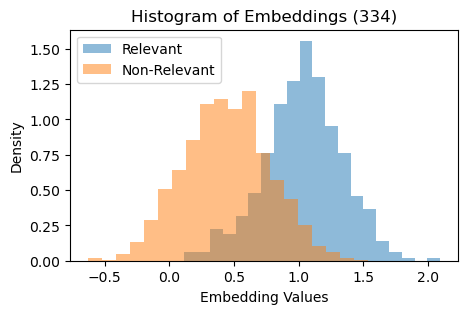

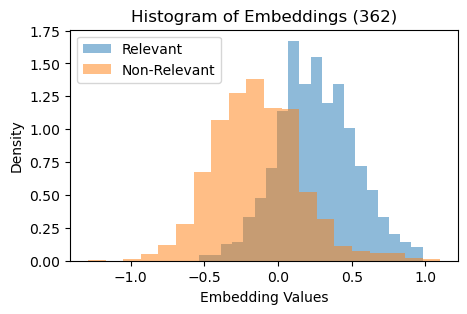

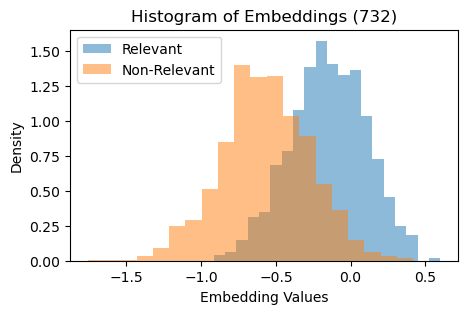

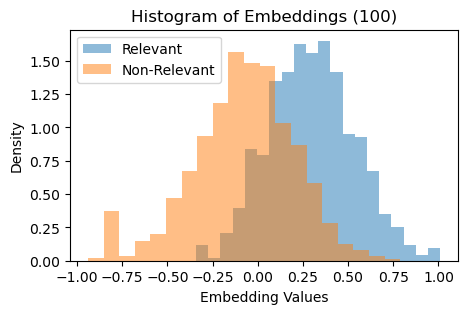

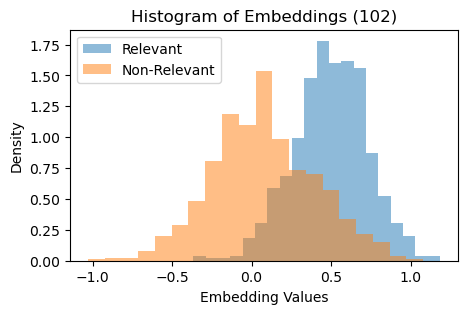

In [115]:
# Sentence Embedding Distribution for important sentence embeddings

positive_coef = ['334', '362', '732', '100', '102']

# Separate data for each group
relevant_articles = train_df.query('target == 1')
nonrelevant_articles = train_df.query('target != 1')

for col in positive_coef:
    plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
    plt.hist(relevant_articles[col], bins=20, alpha=0.5, label='Relevant', density=True)
    plt.hist(nonrelevant_articles[col], bins=20, alpha=0.5, label='Non-Relevant', density=True)
    plt.xlabel('Embedding Values')
    plt.ylabel('Density')
    plt.title(f'Histogram of Embeddings ({col})')
    plt.legend()
    plt.show()



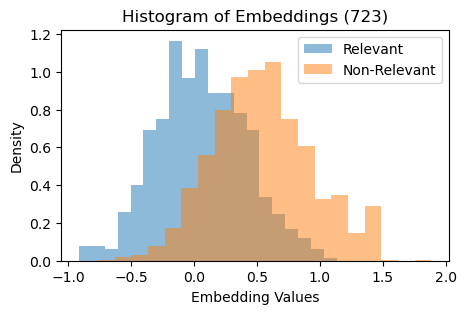

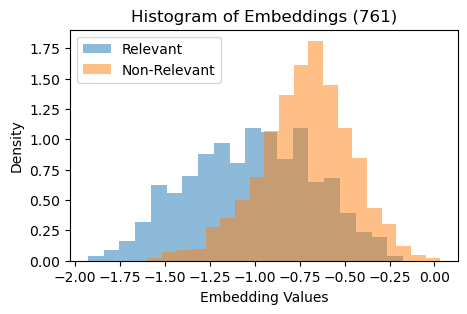

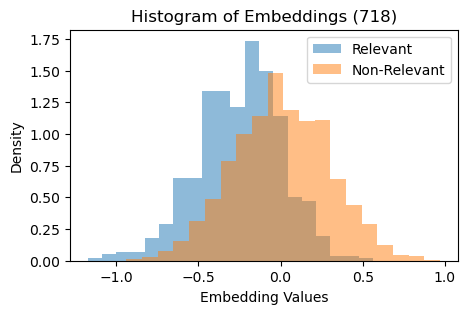

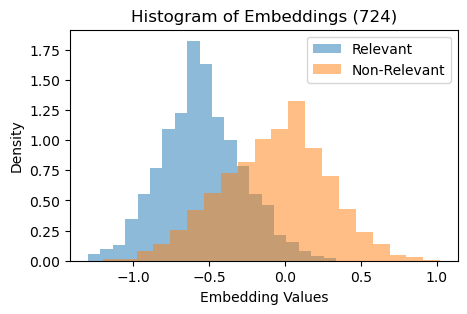

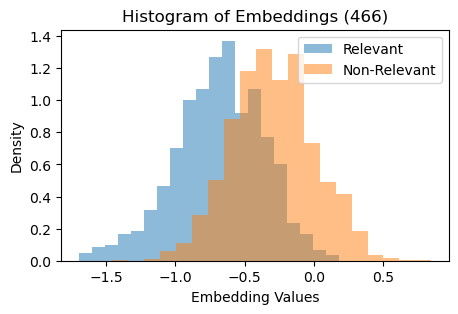

In [116]:
negative_coef = ['723', '761', '718', '724', '466']

# Separate data for each group
relevant_articles = train_df.query('target == 1')
nonrelevant_articles = train_df.query('target != 1')

for col in negative_coef:
    plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
    plt.hist(relevant_articles[col], bins=20, alpha=0.5, label='Relevant', density=True)
    plt.hist(nonrelevant_articles[col], bins=20, alpha=0.5, label='Non-Relevant', density=True)
    plt.xlabel('Embedding Values')
    plt.ylabel('Density')
    plt.title(f'Histogram of Embeddings ({col})')
    plt.legend()
    plt.show()

> The embedding distribution is quite separated between the two groups

#### Embedding & Text Features

In [124]:
transformed_X_train_df_target = pd.merge(transformed_X_train_df_target, metadata_df_cleaned['text_with_abstract'], left_index=True, right_index=True)

In [130]:
def word_cloud(embedding, num_example = 10):
    text_large_coef = " ".join(transformed_X_train_df_target.sort_values(by = embedding, ascending = False).head(num_example)['text_with_abstract'].tolist())
    text_small_coef = " ".join(transformed_X_train_df_target.sort_values(by = embedding, ascending = False).tail(num_example)['text_with_abstract'].tolist())
    
    print('===============================')
    print(f" ======= Embedding: {embedding}, Coefficient: {coef_df.loc[embedding, 'coefficient']} ======= ")
    wordcloud = WordCloud(max_font_size=40, width=600, height=300)
    wordcloud.generate(text_large_coef).to_image()
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for {num_example} examples with HIGHEST value of embedding {embedding}.")
    plt.show()

    df_subset = transformed_X_train_df_target.sort_values(by = embedding, ascending = False).head(num_example)

    for index, row in df_subset.iterrows():
        print("===")
        pred_val = row['target']
        pred_proba_val= row['predict_proba']
        print(f"Example index {index}: prediction = {pred_val}, predict_proba = {pred_proba_val}")
        print(row['text_with_abstract'])

    wordcloud = WordCloud(max_font_size=40, width=600, height=300)
    wordcloud.generate(text_small_coef).to_image()
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for {num_example} examples with LOWEST value of embedding {embedding}.")
    plt.show()
    
    df_subset = transformed_X_train_df_target.sort_values(by = embedding, ascending = False).tail(num_example)
    for index, row in df_subset.iterrows():
        print("===")
        pred_val = row['target']
        pred_proba_val= row['predict_proba']
        print(f"Example index {index}: prediction = {pred_val}, predict_proba = {pred_proba_val}")
        print(row['text_with_abstract'])

 ======= Embedding: 334, Coefficient: 0.22454127068466592 ======= 


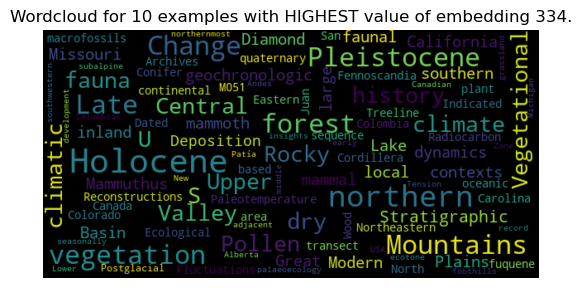

===
Example index 536: prediction = 1, predict_proba = 0.9926472754739624
Stratigraphic and geochronologic contexts of mammoth (Mammuthus) and other Pleistocene fauna, Upper Missouri Basin (northern Great Plains and Rocky Mountains), U.S.A.  
===
Example index 48: prediction = 1, predict_proba = 0.9974142860708807
Late Pleistocene large mammal faunal dynamics from inland southern California: The Diamond Valley Lake local fauna  
===
Example index 481: prediction = 1, predict_proba = 0.9953096221959499
Modern Pollen Deposition and Holocene Paleotemperature Reconstructions, Central Northern Canada  
===
Example index 230: prediction = 1, predict_proba = 0.9991774907492854
Holocene vegetation and climate history on a continental-oceanic transect in northern Fennoscandia based on pollen and plant macrofossils  
===
Example index 431: prediction = 1, predict_proba = 0.9918444132692019
Late‐Pleistocene Vegetational Changes in Northeastern North Carolina Ecological Archives M051-001 
===
Exam

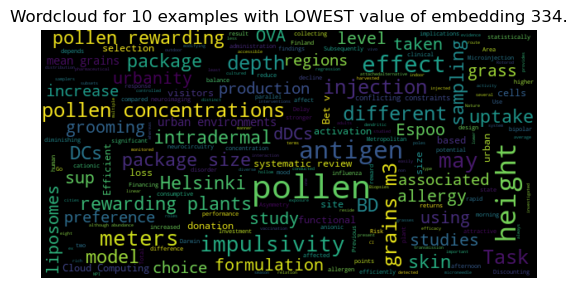

===
Example index 3005: prediction = 0, predict_proba = 0.03758820498962997
The effect of sampling height on grass pollen concentrations in different urban environments in the Helsinki Metropolitan Area, Finland  It is important to study potential differences in pollen concentrations between sampling heights because of diverse outdoor and indoor activity of humans (exposure) at different height levels in urban environments. Previous studies have investigated the effect of height on pollen concentrations based on just one or a few sampling points. We studied the effect of sampling height on grass pollen concentrations in several urban environments with different levels of urbanity. This study was conducted in the Helsinki Metropolitan Area, Finland, in 2013 during the pollen season of grasses. Pollen grains were monitored in eight different points in the morning and afternoon. Rotorod-type samplers were attached on sampling poles at the heights of 1.5 meters and 4 meters. Grass pollen c

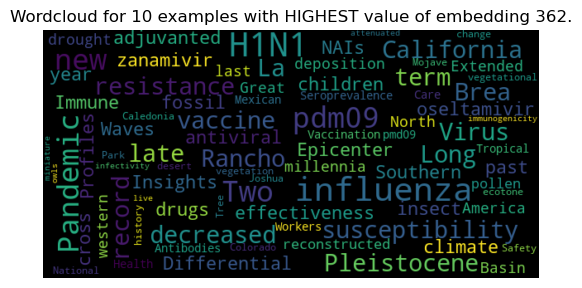

===
Example index 1020: prediction = 0, predict_proba = 0.004833921128875893
Long term effectiveness of adjuvanted influenza A(H1N1)pdm09 vaccine in children  
===
Example index 1210: prediction = 0, predict_proba = 0.01127684939644093
Differential Immune Profiles in Two Pandemic Influenza A(H1N1)pdm09 Virus Waves at Pandemic Epicenter  
===
Example index 1757: prediction = 0, predict_proba = 0.007615153810683483
Influenza A(H1N1)pdm09 resistance and cross-decreased susceptibility to oseltamivir and zanamivir antiviral drugs Resistance and Decreased Susceptibility to NAIs 
===
Example index 129: prediction = 1, predict_proba = 0.9973385999469069
A 50,000 year insect record from Rancho La Brea, Southern California: Insights into past climate and fossil deposition  
===
Example index 361: prediction = 1, predict_proba = 0.9903211648454523
Extended drought in the Great Basin of western North America in the last two millennia reconstructed from pollen records  
===
Example index 2169: pred

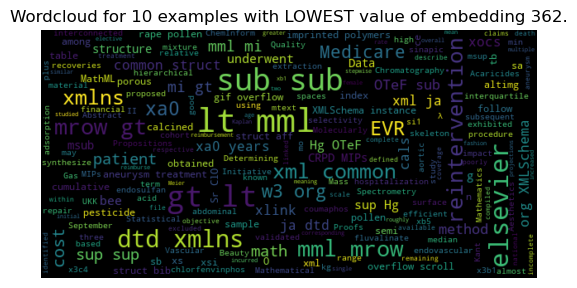

===
Example index 1908: prediction = 0, predict_proba = 0.03555838823261156
Statistical Data and Mathematical Propositions Statistical Data and Mathematical Propositions 
===
Example index 3493: prediction = 0, predict_proba = 0.002185171416898568
Medicare costs for endovascular abdominal aortic aneurysm treatment in the Vascular Quality Initiative  Reintervention after endovascular repair (EVR) of abdominal aortic aneurysms is common. However, the cumulative financial impact of reintervention after EVR on a national scale is poorly defined. Our objective was to describe the cost to Medicare for aneurysm treatment (EVR plus reinterventions) among a cohort of patients with known follow-up for 5&#xa0;years after repair. We identified patients who underwent EVR within the Vascular Quality Initiative who were linked to their respective Medicare claims file (n&#xa0;= 13,995). We excluded patients who underwent EVR after September 30, 2010, and those who had incomplete Medicare coverage (n&#

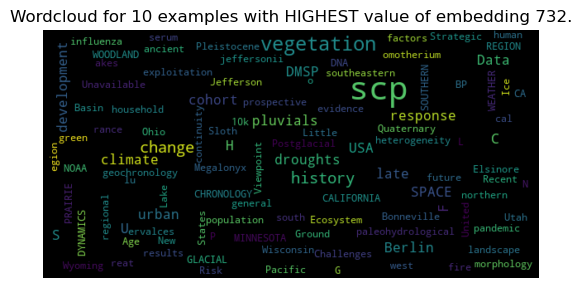

===
Example index 639: prediction = 1, predict_proba = 0.9990737099601636
Ecosystem and paleohydrological response to Quaternary climate change in the Bonneville Basin, Utah  
===
Example index 92: prediction = 1, predict_proba = 0.9968159721896794
A late Wisconsin (32-10k cal a BP) history of pluvials, droughts and vegetation in the Pacific south-west United States (Lake Elsinore, CA) CALIFORNIA'S GLACIAL HISTORY OF PLUVIALS, DROUGHTS AND VEGETATION 
===
Example index 560: prediction = 1, predict_proba = 0.9944950588586348
CHRONOLOGY AND DYNAMICS OF VEGETATION CHANGE IN THE PRAIRIE-WOODLAND REGION OF SOUTHERN MINNESOTA, U.S.A. *  
===
Example index 2025: prediction = 0, predict_proba = 0.2668027169925177
Recent DMSP Data Unavailable From NOAA DMSP SPACE WEATHER DATA 
===
Example index 123: prediction = 1, predict_proba = 0.18858072544839224
<i>
              <scp>H</scp>
              omotherium serum
            </i>
            and
            <i>
              <scp>C</scp>
        

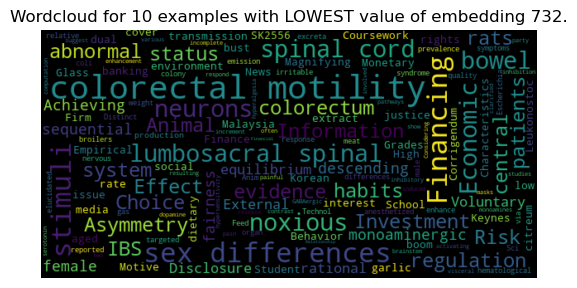

===
Example index 1789: prediction = 0, predict_proba = 0.033589905306255545
Monetary transmission during low interest rate environment in a dual banking system: evidence from Malaysia  
===
Example index 1478: prediction = 0, predict_proba = 0.010879904306122967
Economic News Through the Magnifying Glass How the media cover economic boom and bust 
===
Example index 1951: prediction = 0, predict_proba = 0.012217939814102923
Keynes’ Finance Motive and Firm Behavior: Empirical Evidence  
===
Example index 1714: prediction = 0, predict_proba = 0.013562322445666254
Grades, Coursework, and Student Characteristics in High School Economics  
===
Example index 1694: prediction = 0, predict_proba = 0.00884630861794711
Animal rights is a social justice issue  
===
Example index 1866: prediction = 0, predict_proba = 0.012158991269049495
Corrigendum to “Effect of dietary Korean aged garlic extract by Leukonostoc citreum SK2556 on production, hematological status, meat quality, relative organ weigh

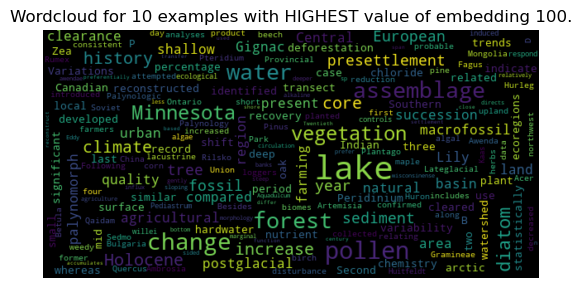

===
Example index 161: prediction = 1, predict_proba = 0.9940149866757755
Present‐day and mid‐Holocene biomes reconstructed from pollen and plant macrofossil data from the former Soviet Union and Mongolia  
===
Example index 278: prediction = 1, predict_proba = 0.9856801784641298
14. Lake Sedmo Rilsko (Bulgaria): Lateglacial vegetation history  
===
Example index 68: prediction = 1, predict_proba = 0.9982969370505096
Holocene vegetation and climate history at Hurleg Lake in the Qaidam Basin, northwest China  
===
Example index 704: prediction = 1, predict_proba = 0.9963830771373234
Palynology of Indian and European forest clearance and farming in lake sediment cores from Awenda Provincial Park, Ontario    Palynologic analyses of four short cores collected along shallow- to deep-water transects in Second and Gignac lakes indicate two periods of forest clearance for farming. The first deforestation was by Huron Indians between A.D. 1450 and 1650, when a maple (Acer), beech (Fagus), and o

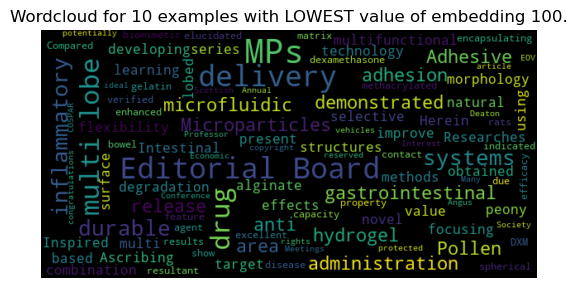

===
Example index 2047: prediction = 0, predict_proba = 0.009138763588482849
Editorial Board  
===
Example index 1977: prediction = 0, predict_proba = 0.008401378179746453
Editorial Board  
===
Example index 1806: prediction = 0, predict_proba = 0.00925223431021965
Editorial Board  
===
Example index 1021: prediction = 0, predict_proba = 0.008401378179746453
Editorial Board  
===
Example index 2491: prediction = 0, predict_proba = 0.010447611866110991
Editorial Board  
===
Example index 4290: prediction = 0, predict_proba = 0.0006582516089998487
Pollen‐Inspired Adhesive Multi‐Lobe Microparticles from Microfluidics for Intestinal Drug Delivery  Microparticles (MPs) based delivery systems have a demonstrated value in gastrointestinal administration. Researches in this area are focusing on developing of multifunctional MPs to improve delivery effects. Herein, learning from the natural morphology of peony pollens, we present novel multi-lobe MPs delivery systems for target surface adhesion

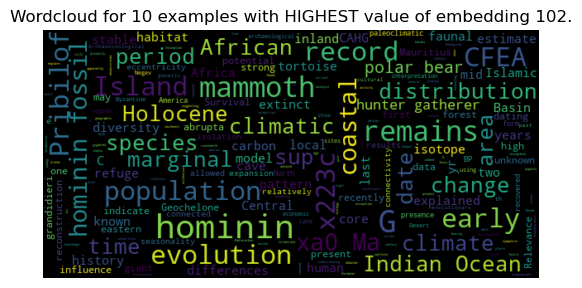

===
Example index 287: prediction = 1, predict_proba = 0.7821878477886
Age and dietary differences of recently extinct Indian Ocean tortoises (
            <i>Geochelone s. lat.</i>
            ) revealed by carbon isotope analysis   
            All but one of the seven or eight species of giant tortoise (
             Geochelone 
            ) in the southwest Indian Ocean became extinct by the mid-nineteenth century, leaving many aspects of their history and biology unknown. Radiocarbon dating of fossil remains indicates that the population of
             G. gigantea 
            on the small island of Assumption was a natural one, predating European activity in the area. It also confirms that the two species known from Mauritius,
             G. inepta 
            and
             G. triserrata 
            , were indeed synchronous and that this was also true of the pair found on Madagascar,
             G. grandidieri 
            and
             G. abrupta 
            . Surv

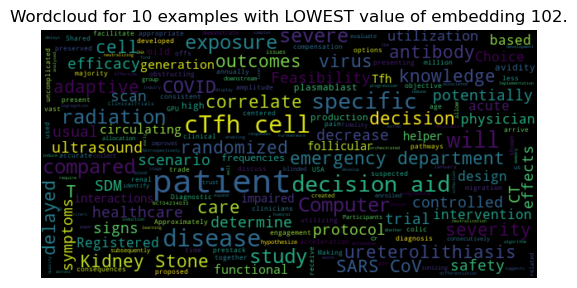

===
Example index 1377: prediction = 0, predict_proba = 0.017448143549274327
GPU acceleration of amplitude-preserved Q compensation prestack time migration  
===
Example index 3164: prediction = 0, predict_proba = 0.0009079309775406386
Feasibility and efficacy of a decision aid for emergency department patients with suspected ureterolithiasis: protocol for an adaptive randomized controlled trial  "Approximately 2 million patients present to emergency departments in the USA annually with signs and symptoms of ureterolithiasis (or renal colic, the pain from an obstructing kidney stone). Both ultrasound and CT scan can be used for diagnosis, but the vast majority of patients receive a CT scan. Diagnostic pathways utilizing ultrasound have been shown to decrease radiation exposure to patients but are potentially less accurate. Because of these and other trade-offs, this decision has been proposed as appropriate for Shared Decision-Making (SDM), where clinicians and patients discuss clinica

In [132]:
positive_coef = ['334', '362', '732', '100', '102']
for col in positive_coef:
    word_cloud(col, num_example = 10)

 ======= Embedding: 723, Coefficient: -0.21191848406417832 ======= 


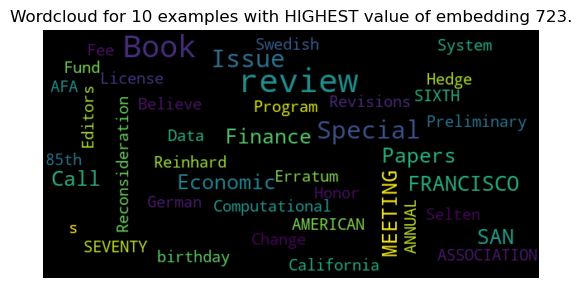

===
Example index 1809: prediction = 0, predict_proba = 0.02616242485031981
The Swedish License-Fee System: Once More Under Reconsideration  
===
Example index 1604: prediction = 0, predict_proba = 0.007555008030017971
Call for Papers: Special Issue of the German Economic Review in Honor of Reinhard Selten’s 85th birthday. Special Issue Editors  
===
Example index 1100: prediction = 0, predict_proba = 0.004482056484830333
Call for Papers “Special Issue on Computational Economics and Finance”  
===
Example index 1960: prediction = 0, predict_proba = 0.018631742086876835
Change You Can Believe In? Hedge Fund Data Revisions: Erratum  
===
Example index 2339: prediction = 0, predict_proba = 0.004312962447467569
Preliminary Program AFA 2016 SAN FRANCISCO MEETINGS SEVENTY SIXTH ANNUAL MEETING AMERICAN FINANCE ASSOCIATION San Francisco, California 
===
Example index 2228: prediction = 0, predict_proba = 0.012309413646843518
Book review  
===
Example index 1022: prediction = 0, predict_proba =

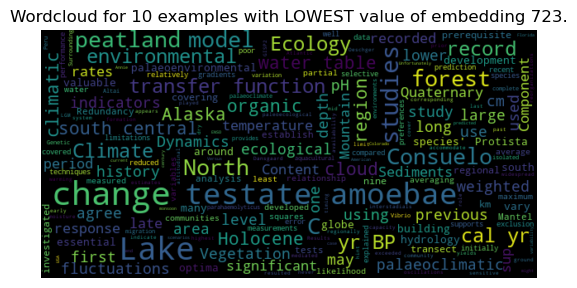

===
Example index 329: prediction = 1, predict_proba = 0.9461434371664128
Ecology of testate amoebae (Protista) in south-central Alaska peatlands:                 building transfer-function models for palaeoenvironmental studies    Testate amoebae are valuable indicators of peatland hydrology and have been used in many palaeoclimatic studies in peatlands. Because the species' ecological optima may vary around the globe, the development of transfer function models is an essential prerequisite for regional palaeoclimatic studies using testate amoebae. We investigated testate amoebae ecology in nine peatlands covering a 250-km north-south transect in south-central Alaska. Redundancy analysis and Mantel tests were used to establish the relationship between the measured environmental variables (water-table depth and pH) and testate amoebae communities. Transfer-function models were developed using weighted averaging, weighted average partial least squares and maximum likelihood techniques. 

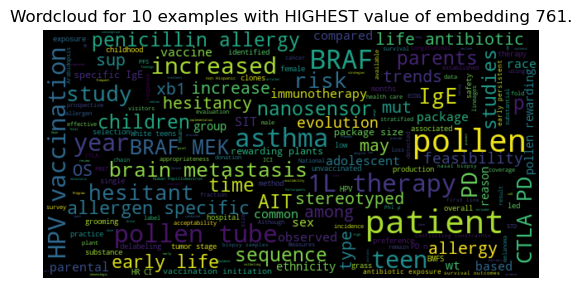

===
Example index 3318: prediction = 0, predict_proba = 0.000876174973031115
Feasibility of a Centralized, Pharmacy-Led Penicillin Allergy Delabeling Program  Penicillin allergy labels are often inaccurate in children and removing unnecessary labels results in improved outcomes and lower health care costs. Although the hospital setting is a frequent point of contact for children, strategies to evaluate penicillin allergies in the hospital are lacking. We performed a prospective pilot study to determine the feasibility of a centralized, pharmacy-led approach to penicillin allergy evaluation. Children with a reported history of penicillin allergy admitted to our children's hospital were risk-stratified and those stratified as low-risk underwent a single-dose oral challenge by a central pharmacist, regardless of the need for antibiotics. After the completion of each patient's delabeling process, surveys were distributed to health care personnel involved in the patient's care to collect pe

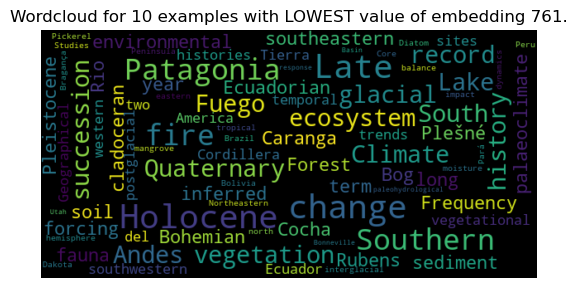

===
Example index 346: prediction = 1, predict_proba = 0.9935433232882056
Holocene Fire Frequency and Climate Change at Rio Rubens Bog, Southern Patagonia  
===
Example index 144: prediction = 1, predict_proba = 0.99899732216797
Late Pleistocene and Holocene environmental change inferred from the Cocha Caranga sediment and soil records in the southeastern Ecuadorian Andes  
===
Example index 0: prediction = 1, predict_proba = 0.997774928195839
The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest  
===
Example index 1: prediction = 1, predict_proba = 0.9980505986339567
Late-glacial and Holocene vegetational history from two sites in the western Cordillera of southwestern Ecuador  
===
Example index 707: prediction = 1, predict_proba = 0.9937956746066312
Geographical and temporal trends in Late Quaternary fire histories of Fuego-Patagonia, South America  
===
Example index 274: prediction = 1, predict_proba = 0

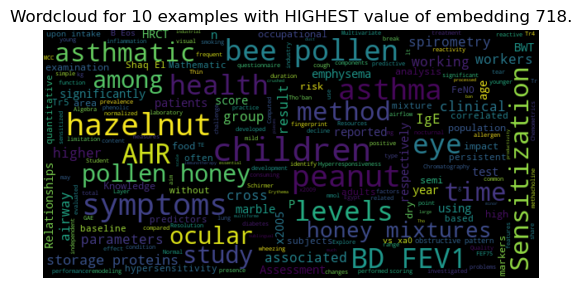

===
Example index 3876: prediction = 0, predict_proba = 0.001514244659802032
Erythema multiforme minor during sublingual immunotherapy  
===
Example index 3894: prediction = 0, predict_proba = 0.002078843446943594
Occupational ocular health problems among marble workers at Shaq El Tho’ban industrial area in Egypt  Eye health of the working population is an essential condition for productivity. Marble industry is processed at large scale at Shaq El Tho'ban area where much dust, crushed pieces of stone, and fluctuating temperatures are endangering employees' health generally and eye health specifically. The objectives of this study were assessing the prevalence of the most common ocular health problems associated with marble industry and investigating the impact of the working environment and occupational risk factors on the oculo-visual status of marble workers. A cross-sectional study was conducted among 250 workers, working at Shaq El Tho'ban area in Egypt during the period from Augus

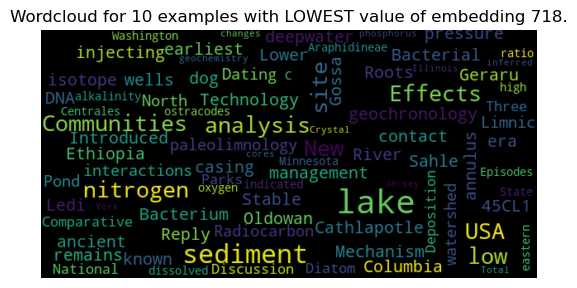

===
Example index 1076: prediction = 0, predict_proba = 0.021731506745593713
Mechanism of pressure management by injecting nitrogen in casing annulus of deepwater wells  
===
Example index 433: prediction = 1, predict_proba = 0.45268860048500376
Effects of an Introduced Bacterium on Bacterial Communities on Roots  
===
Example index 3539: prediction = 0, predict_proba = 0.6694749143194395
Reply to Sahle and Gossa: Technology and geochronology at the earliest known Oldowan site at Ledi-Geraru, Ethiopia  
===
Example index 178: prediction = 1, predict_proba = 0.9780256968391106
Stable isotope and ancient DNA analysis of dog remains from Cathlapotle (45CL1), a contact-era site on the Lower Columbia River  
===
Example index 312: prediction = 1, predict_proba = 0.9950409119135956
The paleolimnology of North Pond: watershed-lake interactions  
===
Example index 306: prediction = 1, predict_proba = 0.9890671615442332
Radiocarbon Dating of Limnic Sediments: A Comparative Analysis and Discussi

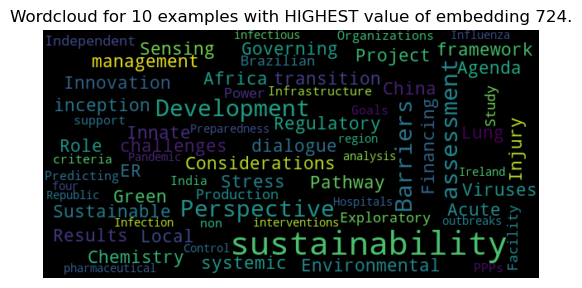

===
Example index 2192: prediction = 0, predict_proba = 0.007825098576717555
Acute Lung Injury Results from Innate Sensing of Viruses by an ER Stress Pathway  
===
Example index 1880: prediction = 0, predict_proba = 0.04462005211315161
Governing sustainability: a dialogue between Local Agenda 21 and transition management  
===
Example index 1768: prediction = 0, predict_proba = 0.017877669028913364
Green Chemistry in Africa – its inception and challenges  
===
Example index 1258: prediction = 0, predict_proba = 0.10272569093483254
A systemic framework for sustainability assessment  
===
Example index 952: prediction = 0, predict_proba = 0.04680881888677765
Environmental Innovation for Sustainable Development: The Role of China  
===
Example index 1718: prediction = 0, predict_proba = 0.011507328156649224
Regulatory Considerations in the Project Financing of an Independent Power Production Facility  
===
Example index 2226: prediction = 0, predict_proba = 0.008919736041317572
Barriers t

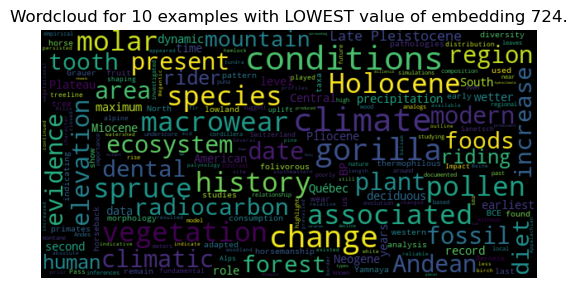

===
Example index 308: prediction = 1, predict_proba = 0.9940856323769307
Impact of Holocene climate changes on alpine and treeline vegetation at Sanetsch Pass, Bernese Alps, Switzerland  
===
Example index 3182: prediction = 1, predict_proba = 0.9784040041477995
Neogene precipitation, vegetation, and elevation history of the Central Andean Plateau  Andean uplift played a fundamental role in shaping South American climate and species distribution, but the relationship between the rise of the Andes, plant composition, and local climatic evolution is poorly known. We investigated the fossil record (pollen, leaves, and wood) from the Neogene of the Central Andean Plateau and documented the earliest evidence of a puna-like ecosystem in the Pliocene and a montane ecosystem without modern analogs in the Miocene. In contrast to regional climate model simulations, our climate inferences based on fossil data suggest wetter than modern precipitation conditions during the Pliocene, when the area 

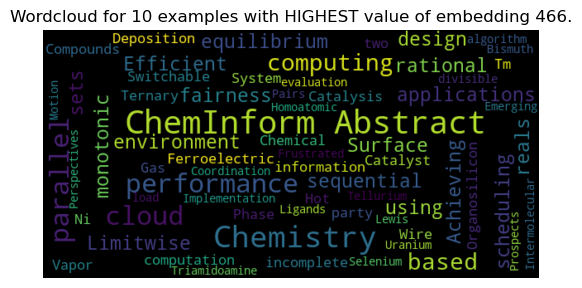

===
Example index 1132: prediction = 0, predict_proba = 0.0019744824242575094
Achieving fairness by sequential equilibrium in rational two-party computation under incomplete information Achieving fairness by sequential equilibrium in rational 
===
Example index 1721: prediction = 0, predict_proba = 0.0028999834422524288
ChemInform Abstract: Ferroelectric-Based Catalysis: Switchable Surface Chemistry  
===
Example index 1224: prediction = 0, predict_proba = 0.003945156039270855
Efficient performance-based design using parallel and cloud computing Efficient Performance-based Design Using Parallel and Cloud Computing 
===
Example index 1539: prediction = 0, predict_proba = 0.06501994022838382
ChemInform Abstract: The Ternary System Tm-Ni-In at 870 K.  
===
Example index 1118: prediction = 0, predict_proba = 0.010959679978992748
ChemInform Abstract: Hot Wire Chemical Vapor Deposition Chemistry in the Gas Phase and on the Catalyst Surface with Organosilicon Compounds  
===
Example index 116

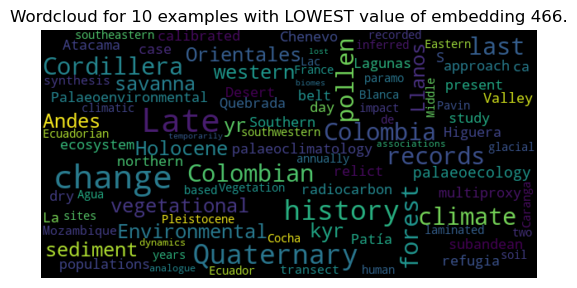

===
Example index 60: prediction = 1, predict_proba = 0.9968511407451971
Late Quaternary palaeoecology and palaeoclimatology from pollen records of the savannas of the Llanos Orientales in Colombia  
===
Example index 393: prediction = 1, predict_proba = 0.9935005921217902
Environmental change in the Colombian subandean forest belt from 8 pollen records: the last 50 kyr  
===
Example index 355: prediction = 1, predict_proba = 0.993597130515527
Late Quaternary climate change, relict populations and present-day refugia in the northern Atacama Desert: a case study from Quebrada La Higuera (18° S)  
===
Example index 546: prediction = 1, predict_proba = 0.9986690391243108
Palaeoenvironmental changes during the last ca. 8590 calibrated yr (7800 radiocarbon yr) in the dry forest ecosystem of the Patía Valley, Southern Colombian Andes: a multiproxy approach  
===
Example index 435: prediction = 1, predict_proba = 0.9806895014881803
Late-Quaternary savanna history of the Colombian Llanos Orien

In [133]:
negative_coef = ['723', '761', '718', '724', '466']
for col in negative_coef:
    word_cloud(col, num_example = 10)

#### 6.3 Model Mistakes on Test dataset

In [134]:
predictions = best_model_lr.predict(X_test)
probs = best_model_lr.predict_proba(X_test)
test_df['predictions'] = predictions
test_df['pred_proba_1'] = probs[:, 1]

In [135]:
# False Positives
test_df.query('target == 0 & predictions == 1')

is-referenced-by-count  has_abstract  \
4384                       0             0   
3489                       3             0   
3167                      36             0   
3811                       3             0   
1473                       0             1   
4197                      23             0   
3625                     236             0   
3400                       4             0   
4391                       8             1   
2753                       1             0   
2809                      14             0   
3628                      10             0   
2158                       9             1   
3563                      17             0   
3044                      15             0   
4335                       0             1   
3951                       2             0   
3989                       0             0   
3847                      15             0   
3235                       2             0   
2941                      28             0   
4002                       5             0   
2735                      50             0   
3299                       9             1   

                                          subject_clean  \
4384                                  Multidisciplinary   
3489  Ecology Ecology, Evolution, Behavior and Syste...   
3167  Anthropology Ecology, Evolution, Behavior and ...   
3811                                  Multidisciplinary   
1473    Computers in Earth Sciences Information Systems   
4197  Genetics Ecology, Evolution, Behavior and Syst...   
3625       Ecology, Evolution, Behavior and Systematics   
3400  Anthropology Ecology, Evolution, Behavior and ...   
4391                  Immunology Immunology and Allergy   
2753  Management, Monitoring, Policy and Law Waste M...   
2809  Paleontology Earth-Surface Processes Ecology A...   
3628                                  Multidisciplinary   
2158  Environmental Science (miscellaneous) Archeolo...   
3563  Anthropology Ecology, Evolution, Behavior and ...   
3044  Anthropology Ecology, Evolution, Behavior and ...   
4335       Ecology, Evolution, Behavior and Systematics   
3951  Plant Science Ecology Ecology, Evolution, Beha...   
3989                      Anthropology General Medicine   
3847  Anthropology Ecology, Evolution, Behavior and ...   
3235                                  Multidisciplinary   
2941                                  Multidisciplinary   
4002  Nature and Landscape Conservation Ecology Ecol...   
2735  Ecology Applied Microbiology and Biotechnology...   
3299                                  Multidisciplinary   

                                     text_with_abstract  target         0  \
4384  Fine-scaled climate variation in equatorial Af...       0  0.620686   
3489  Dual ancestries and ecologies of the Late Glac...       0  0.487718   
3167  Stable isotope paleoecology of Late Pleistocen...       0  0.687200   
3811  Strontium isotope evidence for Neanderthal and...       0  0.636513   
1473  Erratum to “3D hydro-mechanically coupled grou...       0 -0.104258   
4197  Trade‐off between taxon diversity and function...       0  0.486869   
3625  Are specialists at risk under environmental ch...       0  0.409658   
3400  Connections between the Levant and the Balkans...       0  0.402172   
4391   Climate change, airborne pollen, and pollution         0  0.286190   
2753  Assessing mining impacts: The influence of bac...       0  0.857582   
2809  Fuel remains in archaeological contexts: Exper...       0  0.410796   
3628  Al-Ansab and the Dead Sea: Mid-MIS 3 archaeolo...       0  0.291915   
2158  Animal engravings in the central Sahara: A pro...       0  0.248771   
3563  Dietary evidence from Central Asian Neandertha...       0  0.222258   
3044  The morphological affinity of the Early Pleist...       0  0.449500   
4335  Among‐years rain variation is associated with ...       0  0.470583   
3951  Taxon Cycles in Neotropical Mangroves  The con...       0  0.588

In [140]:
# Print out the text for all false positive
FP_df = test_df.query('target == 0 & predictions == 1')

for index, row in FP_df.iterrows():
        print("===")
        print(f"Example index {index}")
        print(row['text_with_abstract'])


===
Example index 4384
Fine-scaled climate variation in equatorial Africa revealed by modern and fossil primate teeth  Variability in resource availability is hypothesized to be a significant driver of primate adaptation and evolution, but most paleoclimate proxies cannot recover environmental seasonality on the scale of an individual lifespan. Oxygen isotope&#xa0;compositions (&#x3b4;<sup>18</sup>O values) sampled at high spatial resolution in the dentitions of modern African primates (<i>n</i> = 2,352 near weekly measurements from 26 teeth) track concurrent seasonal precipitation, regional climatic patterns, discrete meteorological events, and niche partitioning. We leverage these data to contextualize the first &#x3b4;<sup>18</sup>O values of two 17 Ma <i>Afropithecus turkanensis</i> individuals from Kalodirr, Kenya, from which we infer variably bimodal wet seasons, supported by rainfall reconstructions in a global Earth system model. <i>Afropithecus</i>' &#x3b4;<sup>18</sup>O fluct

In [136]:
# False Negatives
test_df.query('target == 1 & predictions == 0')

is-referenced-by-count  has_abstract  \
4051                       7             0   
3952                       8             0   
3649                      19             0   
148                       35             1   
3153                       2             0   

                                          subject_clean  \
4051                                  Multidisciplinary   
3952                                  Multidisciplinary   
3649  General Environmental Science Ecology Environm...   
148   Paleontology Ecology, Evolution, Behavior and ...   
3153  Pollution Waste Management and Disposal Enviro...   

                                     text_with_abstract  target         0  \
4051  Central European Early Bronze Age chronology r...       1  0.217687   
3952  Critical role of climate change in plant selec...       1  0.330950   
3649  Effects of future climate change on birch abun...       1  0.151413   
148   A general framework for determining cutoff val...       1  0.403553   
3153  Alkalinity and diatom assemblages in lowland s...       1  0.294494   

             1         2         3         4  ...       760       761  \
4051  0.447519  0.089969  0.181926  0.412854  ...  0.659130 -1.022066   
3952  0.224434  0.094585  0.075617  0.842312  ...  0.176455 -0.683422   
3649  0.057513  0.260315  0.300927  0.727962  ...  0.257628 -0.962801   
148  -0.165895 -0.270389 -0.181532  0.586620  ...  0.067820 -1.073519   
3153 -0.140384  0.134414  0.501923  0.630669  ...  0.408172 -1.004594   

           762       763       764       765       766       767  predictions  \
4051 -0.286030 -0.699622 -0.437130 -0.372685 -0.102837 -0.843314            0   
3952 -0.452814 -0.745453 -0.812796  0.039001  0.322093 -0.663409            0   
3649 -0.420879 -0.328038 -0.666120 -0.012610  0.074917 -1.021249            0   
148  -0.334076 -0.434081 -0.712888 -0.471258 -0.501174 -0.776501            0   
3153 -0.331516 -0.397120 -0.502169 -0.061922 -0.856465 -0.735245            0   

      pred_proba_1  
4051      0.294608  
3952      0.412157  
3649      0.318546  
148       0.378013  
3153      0.446254  

[5 rows x 775 columns]

In [141]:
# Print out the text for all false negatives
FN_df = test_df.query('target == 1 & predictions == 0')

for index, row in FN_df.iterrows():
        print("===")
        print(f"Example index {index}")
        print(row['text_with_abstract'])

===
Example index 4051
Central European Early Bronze Age chronology revisited: A Bayesian examination of large-scale radiocarbon dating  In archaeological research, changes in material culture and the evolution of styles are taken as major indicators for socio-cultural transformation. They form the basis for typo-chronological classification and the establishment of phases and periods. Central European Bronze Age material culture from burials reveals changes during the Bronze Age and represents a perfect case study for analyzing phenomena of cultural change and the adoption of innovation in the societies of prehistoric Europe. Our study focuses on the large-scale change in material culture which took place in the second millennium BC and the emergence at the same period of new burial rites: the shift from inhumation burials in flat graves to complex mounds and simple cremation burials. Paul Reinecke was the first to divide the European Bronze Age (EBA) into two phases, Bz A1 and A2. Th